## Optimal controller -- maximum possible performance

This notebook uses Alice's matching code to determine the maximum possible performance

Inputs:

1. a picked peak file, with the peak *boundaries*
1. the length of time an MS1 scan takes
1. the length of time an MS2 scan takes
1. N (for top-N)
1. the minimum intensity for fragmentation

The code then creates a bipartite graph with two types of nodes:

1. scans (of either MS1 or MS2)
1. peaks

An edge is added between a scan and a peak *iff*:

1. the scan start time is within the start and end RT of the peak
1. the peak had an intensity >= the min intensity at the time of the last MS1 scan

i.e. this is showing the best possible top-N performance if, by magic, one could not fragment anything that didn't turn into a peak.

In [5]:
import sys
import bisect

In [6]:
pymzm_folder = '/Users/simon/git/pymzm'
pymzm_folder = '/home/simon/git/pymzm'
vimms_folder = '/home/simon/git/vimms/'

In [7]:
sys.path.append(pymzm_folder)
sys.path.append(vimms_folder)

Local package import

In [8]:
from mass_spec_utils.data_import.mzml import MZMLFile
from mass_spec_utils.data_import.mzmine import load_picked_boxes,map_boxes_to_scans
from vimms.Roi import Roi

## Define parameters

In [34]:
min_rt = 0 # start value
max_rt = 26*60 # end value
topn_time_dict = {1: 0.60,2:0.20} # how long do the different scan types take
N = 10 # top-N value
min_ms1_intensity = 5e3 # min intensity for fragmentation
pp_file_path = '/home/simon/git/vimms/experimental/data_20200503/TopN_vs_ROI/from_controller_TopN_QCB_pp.csv'
mzml_file_path = '/home/simon/git/vimms/experimental/data_20200503/TopN_vs_ROI/from_controller_TopN_QCB.mzML'
verbose = True



### 1. Load the picked peak boxes

In [35]:
boxes = load_picked_boxes(pp_file_path)
print("Loaded {} picked peak boxes".format(len(boxes)))

Loaded 5667 picked peak boxes


### 2. Load the mzml file

In [36]:
mzfile  = MZMLFile(mzml_file_path)

Loaded 7045 scans


### 3. Set up the scan times

In [37]:
scan_levels = []
scan_start_times = []
time = 0
while True:
    # add an MS1
    scan_levels.append(1)
    scan_start_times.append(time)
    time += topn_time_dict[1]
    if time > max_rt:
        break
    # add N MS2
    for n in range(N):
        scan_levels.append(2)
        scan_start_times.append(time)
        time += topn_time_dict[2]
        if time > max_rt:
            break
print("Created {} scan times and levels".format(len(scan_levels)))

Created 6601 scan times and levels


### 4. Add ROIs to the peak boxes

In [38]:
# reset in case we run more than once
for box in boxes:
    box.roi = None
    
for i,scan in enumerate(mzfile.scans):
    if scan.ms_level == 2:
        continue # skip MS2 scans
    if verbose and i%100 == 0:
        print(i,len(mzfile.scans))
        
    scan_rt = scan.rt_in_seconds
    
    # find the boxes that are active at this scan
    ok_boxes = list(filter(lambda x: x.rt_range_in_seconds[0] <= scan_rt and x.rt_range_in_seconds[1] >= scan_rt,boxes))
    if len(ok_boxes) == 0:
        continue # no boxes now, onto the next scan
    
    mz_list,intensity_list = zip(*scan.peaks)
    for box in ok_boxes:
        
        min_idx = bisect.bisect_right(mz_list,box.mz_range[0])
        max_idx = bisect.bisect_right(mz_list,box.mz_range[1])
        sub_peaks = []
        for i in range(min_idx,max_idx):
            sub_peaks.append((mz_list[i],intensity_list[i]))
        if len(sub_peaks) > 0:
            sub_peaks.sort(key = lambda x: x[1],reverse = True) # sort by descending intensity
            peak_mz = sub_peaks[0][0]
            peak_intensity = sub_peaks[0][1]
            peak_rt = scan_rt

            if box.roi is None:
                box.roi = Roi(peak_mz,peak_rt,peak_intensity)
            else:
                box.roi.add(peak_mz,peak_rt,peak_intensity)
                
n_with_roi = 0
for box in boxes:
    if box.roi is not None:
        n_with_roi += 1
print("Of {} boxes, {} have roi".format(len(boxes),n_with_roi))

0 7045
1100 7045
2200 7045
3300 7045
4400 7045
5500 7045
6500 7045
Of 5667 boxes, 5667 have roi


In [39]:
# a little test
box_pos = 2345
print(boxes[box_pos],boxes[box_pos].rt_range_in_seconds)
print(boxes[box_pos].roi.mz_list)

5656: [465.10211181640625, 465.1034851074219] [8.70962672321667, 8.9482872112] [522.5776033930002, 536.897232672]
[465.1025, 465.10242, 465.1029, 465.10272, 465.1035]


### 5. Make the graph edges

1. Loop over the boxes
1. Find all MS1 scans at which the intensity exceeds the minmum
1. Add edges to all ms2 scans within the block

Note:
 - This method ignores the intensity *at the MS2 scan time*


In [76]:
def get_intensity(roi,rt):
    if rt < roi.rt_list[0] or rt > roi.rt_list[-1]:
        return 0
    else:
        pos = bisect.bisect_right(roi.rt_list,rt)
        before_pos = pos - 1
        after_pos = pos
        prop = (rt - roi.rt_list[before_pos])/(roi.rt_list[after_pos] - roi.rt_list[before_pos])
        return roi.intensity_list[before_pos] + prop*(roi.intensity_list[after_pos] - roi.intensity_list[before_pos])

edges = []

for box in boxes:
    peak_id = box.peak_id
    rt_start = box.rt_range_in_seconds[0]
    rt_end = box.rt_range_in_seconds[1]
    spo = bisect.bisect_left(scan_start_times,rt_start)
    can_fragment = False # until we see an MS1
    while spo < len(scan_start_times) and scan_start_times[spo] < rt_end:
        if scan_levels[spo] == 1:
            ms1_intensity = get_intensity(box.roi,scan_start_times[spo])
            if  ms1_intensity >= min_ms1_intensity:
                can_fragment = True
            else:
                can_fragment = False
        if scan_levels[spo] == 2:
            if can_fragment:
                edges.append(("S{}".format(spo),"B{}".format(peak_id),box))
        spo += 1
print("{} possible edges found".format(len(edges)))

493566 possible edges found


In [78]:
edge_pos = 0
scan_pos = int(edges[edge_pos][0][1:])
box = edges[edge_pos][2]
scan_rt = scan_start_times[scan_pos]
print(scan_rt)
print(box.rt_range_in_seconds)
print(box.roi.intensity_list)

619.4000000000057
[616.203014337, 682.859708143998]
[6218.936, 26377.29, 99240.67, 222041.62, 364949.5, 993382.6, 2865651.8, 12269144.0, 33528114.0, 56799390.0, 77447670.0, 71707464.0, 62696604.0, 58856240.0, 37672884.0, 15446857.0, 6794234.5, 2674198.8, 1574278.9, 941592.7, 662565.06, 400784.7, 338497.75, 246819.2, 219262.45, 161773.52, 78166.08, 68409.41]


### 6. Do the matching

In [79]:
import networkx as nx
def reducedUnweightedMaxMatchingFromLists(scanList,boxList,edgeList):
    G = nx.Graph() #create an empty graph
    G.add_nodes_from(scanList, bipartite=0) #add both lists of vertices as nodes to graph
    G.add_nodes_from(boxList, bipartite=1)
    G.add_edges_from(edgeList) # add edges to graph from list
    print('There are {} scans and {} boxes'.format(len(scanList),len(boxList)))
    print('There are {} edges in total'.format(len(edgeList)))
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0} #scans
    matching  = nx.bipartite.matching.hopcroft_karp_matching(G,top_nodes) #call the matching algorithms
    size = 0
    matchList = [] # list to accomodate the (scan, box) pairs
    for scan in scanList:
        matchList.append((scan, '-')) # default - box part of each pair is blank
    res1 = list(matching.items())[:len(matching)//2] #first half of the matching (so we just have the scan:box entries)
    for scan,box in res1: # iterate over reduced matching
        ind = scanList.index(scan) 
        matchList[ind] = (scan, box) #update entry in the matchList
        size += 1
    return matchList,size

In [81]:
scan_list,box_list,box = zip(*edges)
unique_scan_list = list(set(scan_list))
unique_box_list = list(set(box_list))
edge_list = list(zip(scan_list,box_list))
matchList,size = reducedUnweightedMaxMatchingFromLists(unique_scan_list,unique_box_list,edge_list)
print("The matching is of size {}".format(size))
actual_matches = list(filter(lambda x: not x[1] == '-',matchList))
actual_matches.sort(key = lambda x: int(x[0][1:]))
matched_scans,matched_boxes = zip(*actual_matches)
print("{} unique scans, {} unique boxes".format(len(set(matched_scans)),len(set(matched_boxes))))


There are 5880 scans and 3987 boxes
There are 493566 edges in total
The matching is of size 2952
2952 unique scans, 2952 unique boxes


('S170', 'S197', 'S213', 'S287', 'S291', 'S310', 'S356', 'S373', 'S379', 'S395')


## Old stuff

In [297]:
print(edges[:10])
edges.sort()
print(edges[:10])

[(2168, 376), (2169, 376), (2170, 376), (2171, 376), (2172, 376), (2173, 376), (2174, 376), (2175, 376), (2176, 376), (2177, 376)]
[(133, 177), (133, 1114), (133, 1745), (133, 3935), (134, 177), (134, 1114), (134, 1745), (134, 3935), (135, 177), (135, 1114)]


In [298]:
import csv
orig_edges = []
with open('/home/simon/git/vimms/experimental/graph_optimal/qca_5e3_edges.csv','w') as f:
    writer = csv.writer(f)
    for scan,peak in edges:
        writer.writerow(['S{}'.format(scan),'B{}'.format(peak)])
        orig_edges.append(['B{}'.format(peak),'S{}'.format(scan)])

In [94]:
edges = set(edges)

In [95]:
print(len(edges))

769853


Check the initial results

In [303]:
res_file = '/home/simon/git/vimms/experimental/graph_optimal/qcb_edgesResults.txt'
matches = []
with open(res_file,'r') as f:
    reader = csv.reader(f,delimiter = ',')
    for line in reader:
        if len(line) < 2:
            continue
        if '.' in line[0]:
            continue
        matches.append(line)
unique_boxes = set([x[0] for x in matches])
dashes = list(filter(lambda x: x[1] == '-',matches))
matches = list(filter(lambda x: not x[1] == '-',matches))
print(len(unique_boxes))
print(len(dashes))

original_unique_boxes = set((x[0] for x in orig_edges))
print(len(original_unique_boxes))

5662
971
3348


In [304]:
unique_boxes = set([x[0] for x in matches])
unique_scans = set([x[1] for x in matches])
print(len(unique_boxes))
print(len(unique_scans))

4691
4691


In [256]:
# make a schedule
schedule = []
box_dict = {b.peak_id:b for b in boxes}
count = 0
for i,(level,time) in enumerate(zip(scan_levels,scan_start_times)):
    s_id = 'S{}'.format(i)
    if level == 1:
        schedule.append(('MS1',None,time,None,pp_file))
        match = list(filter(lambda x: x[1] == s_id,matches))
        assert len(match) == 0
    else:
        # find it in the matching
        match = list(filter(lambda x: x[1] == s_id,matches))
        assert len(match) <= 1
        if len(match) == 0:
            schedule.append(('MS2',-1,time,None,pp_file)) # set precursor to -1 to indicate empty
        else:
            count += 1
            box_id = int(match[0][0][1:])
            box = box_dict[box_id]
            mz = box.mz
            schedule.append(['MS2',mz,time,box_id,pp_file])
print(count)

AssertionError: 

In [230]:
with open('/home/simon/git/vimms/experimental/graph_optimal/qcb_schedule.csv','w') as f:
    writer = csv.writer(f)
    for row in schedule:
        writer.writerow(row)

# score by distance from apex

- Compute a score from 1 to 10 where 10 is as close to the apex as possible and then decay as the scans get further away

In [148]:
# Match the boxes back to the original signal

In [150]:
from mass_spec_utils.data_import.mzml import MZMLFile

In [152]:
# loop over scans, adding intensity values to the boxes

In [233]:
sub_boxes = [boxes[0]]
print(sub_boxes)

In [236]:
print(boxes[0].roi)
print(boxes[0])

ROI with data points=29 mz (258.1107-258.1099) rt (616.2030-682.8597)
2487: [258.1098327636719, 258.1106872558594] [10.27005023895, 11.380995135733299]


(0, 6000000.0)

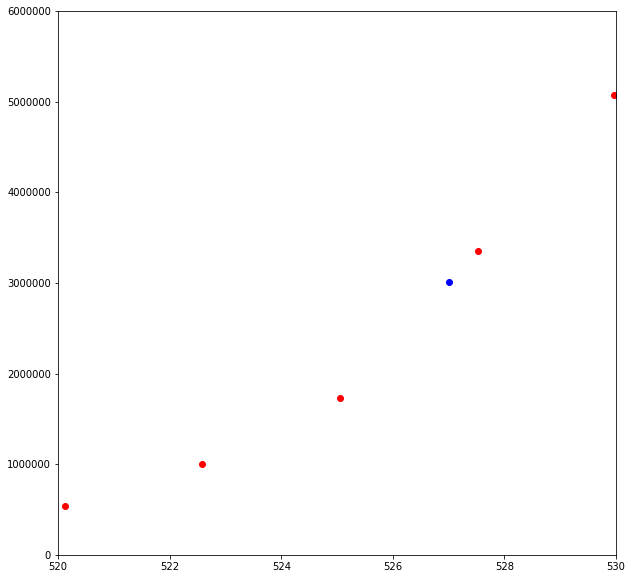

In [247]:
import pylab as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.plot(boxes[1].roi.rt_list,boxes[1].roi.intensity_list,'ro')
plt.xlim([520,530])
plt.plot(527,get_intensity(boxes[1].roi,527),'bo')
plt.ylim([0,6e6])

In [248]:
import bisect


In [253]:
count = 0
total = 0
no_roi = 0
for level,precursor,time,box_id,_ in schedule:
    if level == 'MS2' and precursor > -1:
        total +=1
        box = box_dict[box_id]
        if not box.roi is None:
            intensity = get_intensity(box.roi,time)
            if intensity >= 5e3:
                count += 1
        else:
            no_roi += 1
print(count,total,no_roi)

2144 4324 27
